[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bobleesj/quantem.widget/blob/main/notebooks/edit2d/edit2d_simple.ipynb)
# Edit2D — Quick Demo
Interactive crop and pad tool for 2D images.

In [1]:
# Install in Google Colab
try:
    import google.colab
    !pip install -q -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ quantem-widget
except ImportError:
    pass  # Not in Colab, skip

In [2]:
try:
    %load_ext autoreload
    %autoreload 2
    %env ANYWIDGET_HMR=1
except Exception:
    pass  # autoreload unavailable (Colab Python 3.12+)

env: ANYWIDGET_HMR=1


In [3]:
import numpy as np
import torch
import quantem.widget
from quantem.widget import Edit2D
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
def make_hrtem(size=256, seed=0):
    """Simulate HRTEM lattice fringes with amorphous edge and shot noise."""
    rng = np.random.default_rng(seed)
    y, x = torch.meshgrid(torch.arange(size, device=device, dtype=torch.float32),
                          torch.arange(size, device=device, dtype=torch.float32), indexing="ij")
    img = torch.zeros((size, size), device=device, dtype=torch.float32)
    freqs = [(0.08, 0.0), (0.06, torch.pi / 3), (0.10, torch.pi / 6)]
    for freq, angle in freqs:
        img += torch.cos(2 * torch.pi * freq * (x * torch.cos(torch.tensor(angle)) + y * torch.sin(torch.tensor(angle))))
    r = torch.sqrt((x - size // 2)**2 + (y - size // 2)**2)
    envelope = 1.0 / (1 + torch.exp(-0.05 * (size // 3 - r)))
    noise = torch.from_numpy(rng.normal(0, 0.3, (size, size)).astype(np.float32)).to(device)
    img = img * envelope + noise
    return img.cpu().numpy()
image = make_hrtem(256)
print(f"Generator ready (device={device})")
print(f"quantem.widget {quantem.widget.__version__}")

Generator ready (device=mps)
quantem.widget 0.4.0a3


In [4]:
# Crop mode — drag the rectangle to select a region
w = Edit2D(image, title="Crop Demo")
w

Edit2D(256x256, crop=256x256 at (0,0), fill=0.0)

In [5]:
# Access the cropped result
result = w.result
print(f"Crop bounds: {w.crop_bounds}")
print(f"Crop size:   {w.crop_size}")
print(f"Result shape: {result.shape}")

Crop bounds: (0, 0, 256, 256)
Crop size:   (256, 256)
Result shape: (256, 256)


In [6]:
# Programmatic bounds — crop with padding
Edit2D(image, bounds=(-20, -20, 276, 276), fill_value=0.0, title="Crop + Pad")

Edit2D(256x256, crop=296x296 at (-20,-20), fill=0.0)

## Mask Mode — Paint or Set a Mask

In [7]:
from quantem.widget import Show2D
# Mask mode — paint interactively or set programmatically
w_mask = Edit2D(image, mode="mask", fill_value=0.0, title="Mask Mode")
w_mask

Edit2D(256x256, mask=0px (0.0%))

Masked pixels: 5025


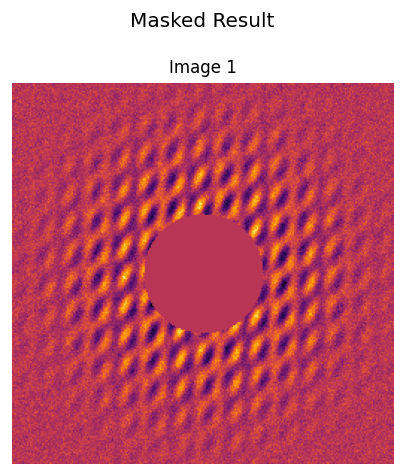

In [8]:
# Set a programmatic mask (circular spot) and view result
cy, cx, r = 128, 128, 40
yy = torch.arange(256, device=device).unsqueeze(1)
xx = torch.arange(256, device=device).unsqueeze(0)
mask_t = ((yy - cy)**2 + (xx - cx)**2 <= r**2).to(torch.uint8)
mask = mask_t.cpu().numpy()
w_mask.mask_bytes = mask.tobytes()
print(f"Masked pixels: {w_mask.mask.sum()}")
Show2D(w_mask.result, title="Masked Result")